# Two-qubit States Reconstruction

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import kraus_error

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

tf.debugging.set_log_device_placement(False)

## Data Generation

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return pnt

In [6]:
#Function to represent the data on the Bloch sphere

def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis
        #ax.plot(y, -x, z, marker='.', c='b', alpha=0.7)

In [7]:
#Choice of simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [8]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [9]:
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]

#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [10]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   return fidelity 

In [11]:
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [12]:
A = tf.stack([X_tf,Y_tf,Z_tf])

In [13]:
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = 1 - fidelity
   return infidelity 

In [14]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b)
   infidelity = 1 - fidelity
   return infidelity 

## Noise Model

In [15]:
#num_qubits = 1

#PROBABILITIES FOR BIT, PHASE, BIT-PHASE FLIP OR DEPOLARIZING CHANNELS
p_error = 0.2
    
#PROBABILITIES FOR GENERAL PAULI CHANNEL
p_0=0.7
p_1=0.2
p_2=0.05
p_3=0.05
    
#PARAMETERS FOR KRAUS CHANNEL
alpha = np.pi / 3
beta = np.pi / 6
    
A_0 = np.array([[np.cos (alpha), 0], [0, np.cos (beta)]])
A_1 = np.array([[0, np.sin (beta)], [np.sin (alpha), 0]])
Kraus_operators = [A_0, A_1]
    
bit_flip_error = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])
bit_phase_flip_error = pauli_error([('Y', p_error), ('I', 1 - p_error)])
#dep_error = depolarizing_error(p_error, num_qubits)
general_pauli_error = pauli_error([('X', p_1), ('Y', p_2), ('Z', p_3), ('I', p_0)])
AD_error = amplitude_damping_error (0.3, 0.5) 
k_error = kraus_error(Kraus_operators)

In [16]:
#applies NOISE whenever an identity gate appears in the circuit (compatibly with the channels parameters)
def qsk_add_error(error_type):
    if error_type == 'bit':
        noise_model.add_all_qubit_quantum_error(bit_flip_error, ["id"])
    if error_type == 'phase':
        noise_model.add_all_qubit_quantum_error(phase_flip_error, ["id"])
    if error_type == 'bit-phase':
        noise_model.add_all_qubit_quantum_error(bit_phase_flip_error, ["id"])
    if error_type == 'depolarizing':
        noise_model.add_all_qubit_quantum_error(dep_error, ["id"])
    if error_type == 'Gpauli':
        noise_model.add_all_qubit_quantum_error(general_pauli_error, ["id"])
    if error_type == 'AD':
        noise_model.add_all_qubit_quantum_error(AD_error, ["id"])
    if error_type == 'Kraus':
        noise_model.add_all_qubit_quantum_error(k_error, ["id"])

##  <font color='green'>Training the Algorithm (MSE)</font>

### <font color='green'>Different Channels on both Qubits</font>

In [17]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [18]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [19]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [20]:
x_train_list = vectors_with_noise[:500]
y_train_list = vectors_noise_free[:500]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [21]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [22]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [23]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 2s 97ms/step - loss: 0.2094 - val_loss: 0.1978
Epoch 2/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.1949 - val_loss: 0.1856
Epoch 3/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1829 - val_loss: 0.1753
Epoch 4/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1723 - val_loss: 0.1655
Epoch 5/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1623 - val_loss: 0.1560
Epoch 6/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1523 - val_loss: 0.1464
Epoch 7/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1422 - val_loss: 0.1367
Epoch 8/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1318 - val_loss: 0.1266
Epoch 9/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1213 - val_loss: 0.1164
Epoch 10/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1106 - val_loss: 0.1062
Epoch 11/

5/5 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 84/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 85/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 86/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 87/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 88/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 89/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 90/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 91/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 92/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 93/1000


5/5 [==============================] - 0s 20ms/step - loss: 5.4602e-04 - val_loss: 9.7430e-04
Epoch 163/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.4495e-04 - val_loss: 9.7225e-04
Epoch 164/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.4864e-04 - val_loss: 9.7927e-04
Epoch 165/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.3794e-04 - val_loss: 9.4277e-04
Epoch 166/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.2929e-04 - val_loss: 9.3140e-04
Epoch 167/1000
5/5 [==============================] - 0s 21ms/step - loss: 5.2461e-04 - val_loss: 9.3442e-04
Epoch 168/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.1712e-04 - val_loss: 9.0954e-04
Epoch 169/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.0910e-04 - val_loss: 9.1049e-04
Epoch 170/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.1019e-04 - val_loss: 9.2102e-04
Epoch 171/1000
5/5 [==============

5/5 [==============================] - 0s 23ms/step - loss: 2.8553e-04 - val_loss: 5.2018e-04
Epoch 238/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.7793e-04 - val_loss: 5.0434e-04
Epoch 239/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.7095e-04 - val_loss: 5.0461e-04
Epoch 240/1000
5/5 [==============================] - 0s 23ms/step - loss: 2.6908e-04 - val_loss: 4.9606e-04
Epoch 241/1000
5/5 [==============================] - 0s 19ms/step - loss: 2.6505e-04 - val_loss: 5.0175e-04
Epoch 242/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.6658e-04 - val_loss: 4.9429e-04
Epoch 243/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.6348e-04 - val_loss: 4.7968e-04
Epoch 244/1000
5/5 [==============================] - 0s 23ms/step - loss: 2.5726e-04 - val_loss: 4.9398e-04
Epoch 245/1000
5/5 [==============================] - 0s 25ms/step - loss: 2.5999e-04 - val_loss: 4.7337e-04
Epoch 246/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 1.4499e-04 - val_loss: 2.6568e-04
Epoch 313/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.4169e-04 - val_loss: 2.6915e-04
Epoch 314/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.4169e-04 - val_loss: 2.6901e-04
Epoch 315/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.3830e-04 - val_loss: 2.6466e-04
Epoch 316/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.3507e-04 - val_loss: 2.5714e-04
Epoch 317/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.3551e-04 - val_loss: 2.5356e-04
Epoch 318/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.3226e-04 - val_loss: 2.5447e-04
Epoch 319/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.3130e-04 - val_loss: 2.5153e-04
Epoch 320/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.2989e-04 - val_loss: 2.4690e-04
Epoch 321/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 6.4785e-05 - val_loss: 1.2671e-04
Epoch 388/1000
5/5 [==============================] - 0s 22ms/step - loss: 6.2948e-05 - val_loss: 1.2372e-04
Epoch 389/1000
5/5 [==============================] - 0s 22ms/step - loss: 6.3379e-05 - val_loss: 1.2159e-04
Epoch 390/1000
5/5 [==============================] - 0s 17ms/step - loss: 6.3265e-05 - val_loss: 1.2151e-04
Epoch 391/1000
5/5 [==============================] - 0s 22ms/step - loss: 6.1943e-05 - val_loss: 1.2647e-04
Epoch 392/1000
5/5 [==============================] - 0s 20ms/step - loss: 6.3978e-05 - val_loss: 1.1928e-04
Epoch 393/1000
5/5 [==============================] - 0s 24ms/step - loss: 6.1789e-05 - val_loss: 1.1816e-04
Epoch 394/1000
5/5 [==============================] - 0s 24ms/step - loss: 5.9445e-05 - val_loss: 1.1329e-04
Epoch 395/1000
5/5 [==============================] - 0s 21ms/step - loss: 5.8665e-05 - val_loss: 1.1561e-04
Epoch 396/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 2.7182e-05 - val_loss: 5.8427e-05
Epoch 463/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.5382e-05 - val_loss: 5.6263e-05
Epoch 464/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.4248e-05 - val_loss: 5.7797e-05
Epoch 465/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.5146e-05 - val_loss: 5.8066e-05
Epoch 466/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.4443e-05 - val_loss: 5.4648e-05
Epoch 467/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.2808e-05 - val_loss: 5.3974e-05
Epoch 468/1000
5/5 [==============================] - 0s 21ms/step - loss: 2.2352e-05 - val_loss: 5.3014e-05
Epoch 469/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.2937e-05 - val_loss: 5.3704e-05
Epoch 470/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.1983e-05 - val_loss: 5.3562e-05
Epoch 471/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 8.7377e-06 - val_loss: 3.0739e-05
Epoch 538/1000
5/5 [==============================] - 0s 25ms/step - loss: 9.5988e-06 - val_loss: 2.9469e-05
Epoch 539/1000
5/5 [==============================] - 0s 26ms/step - loss: 9.3348e-06 - val_loss: 2.8397e-05
Epoch 540/1000
5/5 [==============================] - 0s 24ms/step - loss: 8.8583e-06 - val_loss: 2.8770e-05
Epoch 541/1000
5/5 [==============================] - 0s 20ms/step - loss: 8.3054e-06 - val_loss: 2.8374e-05
Epoch 542/1000
5/5 [==============================] - 0s 20ms/step - loss: 8.0036e-06 - val_loss: 2.7989e-05
Epoch 543/1000
5/5 [==============================] - 0s 28ms/step - loss: 8.0772e-06 - val_loss: 2.7810e-05
Epoch 544/1000
5/5 [==============================] - 0s 18ms/step - loss: 7.5226e-06 - val_loss: 2.8141e-05
Epoch 545/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.3212e-06 - val_loss: 2.8051e-05
Epoch 546/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 3.1169e-06 - val_loss: 2.1031e-05
Epoch 613/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.6339e-06 - val_loss: 1.9874e-05
Epoch 614/1000
5/5 [==============================] - 0s 21ms/step - loss: 3.4490e-06 - val_loss: 1.9497e-05
Epoch 615/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.0666e-06 - val_loss: 1.9130e-05
Epoch 616/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.8203e-06 - val_loss: 1.9603e-05
Epoch 617/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.9225e-06 - val_loss: 1.8824e-05
Epoch 618/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.8883e-06 - val_loss: 1.9390e-05
Epoch 619/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.6539e-06 - val_loss: 1.8783e-05
Epoch 620/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.7184e-06 - val_loss: 1.8646e-05
Epoch 621/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 2.2458e-05 - val_loss: 3.0914e-05
Epoch 688/1000
5/5 [==============================] - 0s 20ms/step - loss: 9.4730e-06 - val_loss: 2.1672e-05
Epoch 689/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.4496e-06 - val_loss: 1.9173e-05
Epoch 690/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.9305e-06 - val_loss: 1.8044e-05
Epoch 691/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.9533e-06 - val_loss: 1.9491e-05
Epoch 692/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.7190e-06 - val_loss: 1.7106e-05
Epoch 693/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.8518e-06 - val_loss: 1.6538e-05
Epoch 694/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.4018e-06 - val_loss: 2.1787e-05
Epoch 695/1000
5/5 [==============================] - 0s 19ms/step - loss: 4.0762e-06 - val_loss: 2.0704e-05
Epoch 696/1000
5/5 [==============

5/5 [==============================] - 0s 24ms/step - loss: 1.0096e-06 - val_loss: 1.5165e-05
Epoch 763/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.2312e-06 - val_loss: 1.5927e-05
Epoch 764/1000
5/5 [==============================] - 0s 28ms/step - loss: 2.0468e-06 - val_loss: 1.7591e-05
Epoch 765/1000
5/5 [==============================] - 0s 21ms/step - loss: 3.4357e-06 - val_loss: 1.5616e-05
Epoch 766/1000
5/5 [==============================] - 0s 23ms/step - loss: 1.3674e-06 - val_loss: 1.4964e-05
Epoch 767/1000
5/5 [==============================] - 0s 23ms/step - loss: 9.4887e-07 - val_loss: 1.5300e-05
Epoch 768/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.7823e-06 - val_loss: 1.9592e-05
Epoch 769/1000
5/5 [==============================] - 0s 22ms/step - loss: 6.9469e-06 - val_loss: 2.0112e-05
Epoch 770/1000
5/5 [==============================] - 0s 24ms/step - loss: 5.6544e-06 - val_loss: 1.8217e-05
Epoch 771/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 8.4973e-06 - val_loss: 4.3002e-05
Epoch 838/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.2620e-05 - val_loss: 2.3065e-05
Epoch 839/1000
5/5 [==============================] - 0s 27ms/step - loss: 1.5272e-05 - val_loss: 2.7957e-05
Epoch 840/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.0854e-05 - val_loss: 2.0119e-05
Epoch 841/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.8911e-06 - val_loss: 1.7572e-05
Epoch 842/1000
5/5 [==============================] - 0s 21ms/step - loss: 3.3319e-06 - val_loss: 1.4979e-05
Epoch 843/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.7161e-06 - val_loss: 1.6067e-05
Epoch 844/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.5045e-06 - val_loss: 1.8099e-05
Epoch 845/1000
5/5 [==============================] - 0s 24ms/step - loss: 3.2169e-06 - val_loss: 1.9760e-05
Epoch 846/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 8.3163e-06 - val_loss: 3.5784e-05
Epoch 913/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.7255e-05 - val_loss: 1.8025e-05
Epoch 914/1000
5/5 [==============================] - 0s 23ms/step - loss: 1.1125e-05 - val_loss: 3.4805e-05
Epoch 915/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0484e-05 - val_loss: 3.5398e-05
Epoch 916/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.1685e-05 - val_loss: 2.4645e-05
Epoch 917/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.2978e-05 - val_loss: 2.6987e-05
Epoch 918/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.4263e-05 - val_loss: 2.0185e-05
Epoch 919/1000
5/5 [==============================] - 0s 20ms/step - loss: 6.9809e-06 - val_loss: 2.8638e-05
Epoch 920/1000
5/5 [==============================] - 0s 25ms/step - loss: 1.0840e-05 - val_loss: 1.9600e-05
Epoch 921/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 8.1179e-07 - val_loss: 1.4934e-05
Epoch 988/1000
5/5 [==============================] - 0s 26ms/step - loss: 9.5178e-07 - val_loss: 1.4912e-05
Epoch 989/1000
5/5 [==============================] - 0s 23ms/step - loss: 6.7851e-07 - val_loss: 1.4597e-05
Epoch 990/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.5025e-06 - val_loss: 1.6838e-05
Epoch 991/1000
5/5 [==============================] - 0s 23ms/step - loss: 3.3860e-06 - val_loss: 1.8518e-05
Epoch 992/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.8705e-06 - val_loss: 2.1023e-05
Epoch 993/1000
5/5 [==============================] - 0s 22ms/step - loss: 7.2683e-06 - val_loss: 3.2163e-05
Epoch 994/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.7848e-05 - val_loss: 1.7299e-05
Epoch 995/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.9511e-05 - val_loss: 4.8128e-05
Epoch 996/1000
5/5 [==============

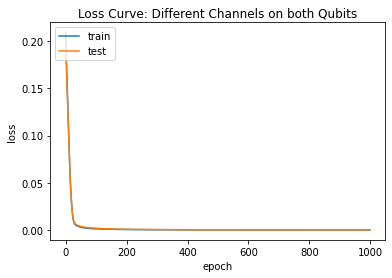

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 1.8553e-05 - 194ms/epoch - 28ms/step


In [26]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_diff_mse = tf.math.reduce_mean(fid)
print(fid_diff_mse)

tf.Tensor((0.99816704+2.8194336e-13j), shape=(), dtype=complex64)


### <font color='green'>Same Channel on both Qubits</font>

In [105]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [106]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [107]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [108]:
x_train_list = vectors_with_noise[:500]
y_train_list = vectors_noise_free[:500]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [109]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [110]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [111]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 2s 67ms/step - loss: 0.2041 - val_loss: 0.1957
Epoch 2/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1889 - val_loss: 0.1833
Epoch 3/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1764 - val_loss: 0.1722
Epoch 4/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1653 - val_loss: 0.1616
Epoch 5/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1543 - val_loss: 0.1509
Epoch 6/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1433 - val_loss: 0.1401
Epoch 7/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1322 - val_loss: 0.1291
Epoch 8/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1211 - val_loss: 0.1181
Epoch 9/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1098 - val_loss: 0.1072
Epoch 10/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0988 - val_loss: 0.0965
Epoch 11/

5/5 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 84/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 85/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 86/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 87/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 88/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 89/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 90/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 91/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 92/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 93/1000


5/5 [==============================] - 0s 26ms/step - loss: 6.2666e-04 - val_loss: 0.0011
Epoch 163/1000
5/5 [==============================] - 0s 20ms/step - loss: 6.1359e-04 - val_loss: 0.0010
Epoch 164/1000
5/5 [==============================] - 0s 22ms/step - loss: 6.0325e-04 - val_loss: 0.0010
Epoch 165/1000
5/5 [==============================] - 0s 22ms/step - loss: 6.0159e-04 - val_loss: 0.0010
Epoch 166/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.8761e-04 - val_loss: 0.0010
Epoch 167/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.8225e-04 - val_loss: 9.8608e-04
Epoch 168/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.7793e-04 - val_loss: 9.9497e-04
Epoch 169/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.7573e-04 - val_loss: 9.8931e-04
Epoch 170/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.7713e-04 - val_loss: 9.8529e-04
Epoch 171/1000
5/5 [==============================] - 

5/5 [==============================] - 0s 20ms/step - loss: 3.3569e-04 - val_loss: 5.9931e-04
Epoch 238/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.2939e-04 - val_loss: 5.9662e-04
Epoch 239/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.2547e-04 - val_loss: 5.9511e-04
Epoch 240/1000
5/5 [==============================] - 0s 21ms/step - loss: 3.2294e-04 - val_loss: 6.0009e-04
Epoch 241/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.1845e-04 - val_loss: 5.8863e-04
Epoch 242/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.1483e-04 - val_loss: 5.8158e-04
Epoch 243/1000
5/5 [==============================] - 0s 21ms/step - loss: 3.1289e-04 - val_loss: 5.7178e-04
Epoch 244/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.1425e-04 - val_loss: 5.8142e-04
Epoch 245/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.1222e-04 - val_loss: 5.8417e-04
Epoch 246/1000
5/5 [==============

5/5 [==============================] - 0s 21ms/step - loss: 1.8755e-04 - val_loss: 3.6915e-04
Epoch 313/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.8560e-04 - val_loss: 3.5861e-04
Epoch 314/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.8432e-04 - val_loss: 3.5347e-04
Epoch 315/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.8172e-04 - val_loss: 3.5427e-04
Epoch 316/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.8497e-04 - val_loss: 3.5830e-04
Epoch 317/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.8338e-04 - val_loss: 3.5169e-04
Epoch 318/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.8144e-04 - val_loss: 3.4284e-04
Epoch 319/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.7981e-04 - val_loss: 3.4434e-04
Epoch 320/1000
5/5 [==============================] - 0s 19ms/step - loss: 1.7492e-04 - val_loss: 3.4072e-04
Epoch 321/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 9.5754e-05 - val_loss: 2.0195e-04
Epoch 388/1000
5/5 [==============================] - 0s 20ms/step - loss: 9.5818e-05 - val_loss: 2.0231e-04
Epoch 389/1000
5/5 [==============================] - 0s 22ms/step - loss: 9.4726e-05 - val_loss: 1.9987e-04
Epoch 390/1000
5/5 [==============================] - 0s 17ms/step - loss: 9.7018e-05 - val_loss: 1.9782e-04
Epoch 391/1000
5/5 [==============================] - 0s 18ms/step - loss: 9.4430e-05 - val_loss: 1.9075e-04
Epoch 392/1000
5/5 [==============================] - 0s 22ms/step - loss: 9.3666e-05 - val_loss: 1.9002e-04
Epoch 393/1000
5/5 [==============================] - 0s 18ms/step - loss: 9.2288e-05 - val_loss: 1.8824e-04
Epoch 394/1000
5/5 [==============================] - 0s 18ms/step - loss: 9.0815e-05 - val_loss: 1.9473e-04
Epoch 395/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.9938e-05 - val_loss: 1.9459e-04
Epoch 396/1000
5/5 [==============

5/5 [==============================] - 0s 21ms/step - loss: 4.6378e-05 - val_loss: 1.0741e-04
Epoch 463/1000
5/5 [==============================] - 0s 24ms/step - loss: 4.4125e-05 - val_loss: 1.0671e-04
Epoch 464/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.3498e-05 - val_loss: 1.0674e-04
Epoch 465/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.4082e-05 - val_loss: 1.0717e-04
Epoch 466/1000
5/5 [==============================] - 0s 21ms/step - loss: 4.5825e-05 - val_loss: 1.0781e-04
Epoch 467/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.4771e-05 - val_loss: 1.0540e-04
Epoch 468/1000
5/5 [==============================] - 0s 21ms/step - loss: 4.3975e-05 - val_loss: 1.0462e-04
Epoch 469/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.3523e-05 - val_loss: 1.0157e-04
Epoch 470/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.2097e-05 - val_loss: 1.0142e-04
Epoch 471/1000
5/5 [==============

5/5 [==============================] - 0s 21ms/step - loss: 2.3990e-05 - val_loss: 6.2807e-05
Epoch 538/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.3193e-05 - val_loss: 6.3512e-05
Epoch 539/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.2333e-05 - val_loss: 6.2570e-05
Epoch 540/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.1702e-05 - val_loss: 5.9820e-05
Epoch 541/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.0283e-05 - val_loss: 5.9247e-05
Epoch 542/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.9856e-05 - val_loss: 5.8565e-05
Epoch 543/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.0100e-05 - val_loss: 5.7735e-05
Epoch 544/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.9702e-05 - val_loss: 5.8110e-05
Epoch 545/1000
5/5 [==============================] - 0s 19ms/step - loss: 2.0101e-05 - val_loss: 6.0057e-05
Epoch 546/1000
5/5 [==============

5/5 [==============================] - 0s 23ms/step - loss: 1.1543e-05 - val_loss: 3.9907e-05
Epoch 613/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.1114e-05 - val_loss: 4.1081e-05
Epoch 614/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.1016e-05 - val_loss: 3.8792e-05
Epoch 615/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0227e-05 - val_loss: 3.8892e-05
Epoch 616/1000
5/5 [==============================] - 0s 25ms/step - loss: 1.1195e-05 - val_loss: 3.8955e-05
Epoch 617/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.0583e-05 - val_loss: 3.9284e-05
Epoch 618/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0968e-05 - val_loss: 3.8383e-05
Epoch 619/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0313e-05 - val_loss: 3.9038e-05
Epoch 620/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.1313e-05 - val_loss: 3.8270e-05
Epoch 621/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 5.7823e-06 - val_loss: 2.8980e-05
Epoch 688/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.2337e-06 - val_loss: 2.8235e-05
Epoch 689/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.0840e-06 - val_loss: 2.8833e-05
Epoch 690/1000
5/5 [==============================] - 0s 28ms/step - loss: 4.8272e-06 - val_loss: 2.8520e-05
Epoch 691/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.8973e-06 - val_loss: 2.8928e-05
Epoch 692/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.8217e-06 - val_loss: 2.7645e-05
Epoch 693/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.8724e-06 - val_loss: 2.8098e-05
Epoch 694/1000
5/5 [==============================] - 0s 24ms/step - loss: 5.1349e-06 - val_loss: 2.8997e-05
Epoch 695/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.7817e-06 - val_loss: 2.7367e-05
Epoch 696/1000
5/5 [==============

5/5 [==============================] - 0s 24ms/step - loss: 2.5332e-06 - val_loss: 2.3963e-05
Epoch 763/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.5675e-06 - val_loss: 2.3152e-05
Epoch 764/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.3286e-06 - val_loss: 2.2913e-05
Epoch 765/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.1979e-06 - val_loss: 2.3215e-05
Epoch 766/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.6937e-06 - val_loss: 2.3117e-05
Epoch 767/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.8131e-06 - val_loss: 2.3183e-05
Epoch 768/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.6605e-06 - val_loss: 2.3788e-05
Epoch 769/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.8225e-06 - val_loss: 2.3030e-05
Epoch 770/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.6910e-06 - val_loss: 2.3616e-05
Epoch 771/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 1.2475e-05 - val_loss: 2.9962e-05
Epoch 838/1000
5/5 [==============================] - 0s 18ms/step - loss: 7.4570e-06 - val_loss: 2.2137e-05
Epoch 839/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.0774e-06 - val_loss: 2.4790e-05
Epoch 840/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.0125e-06 - val_loss: 2.2516e-05
Epoch 841/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.2463e-06 - val_loss: 2.1723e-05
Epoch 842/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.9469e-06 - val_loss: 2.4862e-05
Epoch 843/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.7373e-06 - val_loss: 2.2439e-05
Epoch 844/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.1604e-06 - val_loss: 2.5219e-05
Epoch 845/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.4011e-06 - val_loss: 2.1197e-05
Epoch 846/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 2.5553e-06 - val_loss: 2.1612e-05
Epoch 913/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.9671e-06 - val_loss: 2.0742e-05
Epoch 914/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.4173e-06 - val_loss: 2.0974e-05
Epoch 915/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.4786e-06 - val_loss: 2.1003e-05
Epoch 916/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.6200e-06 - val_loss: 2.0203e-05
Epoch 917/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.0636e-06 - val_loss: 2.0223e-05
Epoch 918/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.0936e-06 - val_loss: 2.0053e-05
Epoch 919/1000
5/5 [==============================] - 0s 22ms/step - loss: 9.8249e-07 - val_loss: 2.0308e-05
Epoch 920/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.3921e-06 - val_loss: 2.0368e-05
Epoch 921/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 1.3768e-06 - val_loss: 2.0852e-05
Epoch 988/1000
5/5 [==============================] - 0s 22ms/step - loss: 8.8734e-07 - val_loss: 2.0095e-05
Epoch 989/1000
5/5 [==============================] - 0s 18ms/step - loss: 9.7555e-07 - val_loss: 2.0056e-05
Epoch 990/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.8523e-06 - val_loss: 2.1735e-05
Epoch 991/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.1647e-06 - val_loss: 2.0625e-05
Epoch 992/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.5924e-06 - val_loss: 2.0485e-05
Epoch 993/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.6420e-06 - val_loss: 2.0634e-05
Epoch 994/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.3074e-06 - val_loss: 2.0692e-05
Epoch 995/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.8674e-06 - val_loss: 2.1152e-05
Epoch 996/1000
5/5 [==============

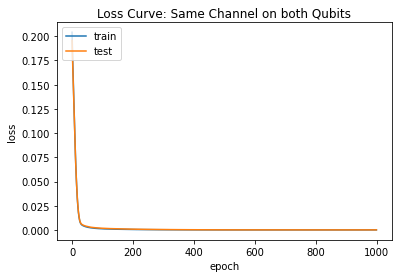

In [112]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [113]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 5.5338e-05 - 210ms/epoch - 30ms/step


In [114]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_mse = tf.math.reduce_mean(fid)
print(fid_same_mse)

tf.Tensor((0.9976302-1.1095836e-12j), shape=(), dtype=complex64)


### <font color='green'>One Channel on One Qubit</font>

In [37]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [38]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [39]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [40]:
x_train_list = vectors_with_noise[:500]
y_train_list = vectors_noise_free[:500]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [41]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [42]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [43]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 2s 66ms/step - loss: 0.2037 - val_loss: 0.1945
Epoch 2/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.1858 - val_loss: 0.1792
Epoch 3/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1704 - val_loss: 0.1656
Epoch 4/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1565 - val_loss: 0.1525
Epoch 5/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.1432 - val_loss: 0.1396
Epoch 6/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.1300 - val_loss: 0.1270
Epoch 7/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1171 - val_loss: 0.1145
Epoch 8/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1044 - val_loss: 0.1024
Epoch 9/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0923 - val_loss: 0.0910
Epoch 10/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0809 - val_loss: 0.0801
Epoch 11/

5/5 [==============================] - 0s 19ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 84/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 85/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 86/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 87/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 88/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 89/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 90/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 91/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 92/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 93/1000


5/5 [==============================] - 0s 18ms/step - loss: 8.2796e-04 - val_loss: 0.0015
Epoch 164/1000
5/5 [==============================] - 0s 20ms/step - loss: 8.2415e-04 - val_loss: 0.0015
Epoch 165/1000
5/5 [==============================] - 0s 22ms/step - loss: 8.2121e-04 - val_loss: 0.0015
Epoch 166/1000
5/5 [==============================] - 0s 20ms/step - loss: 8.0902e-04 - val_loss: 0.0015
Epoch 167/1000
5/5 [==============================] - 0s 20ms/step - loss: 8.1180e-04 - val_loss: 0.0015
Epoch 168/1000
5/5 [==============================] - 0s 21ms/step - loss: 7.9961e-04 - val_loss: 0.0015
Epoch 169/1000
5/5 [==============================] - 0s 24ms/step - loss: 7.9715e-04 - val_loss: 0.0015
Epoch 170/1000
5/5 [==============================] - 0s 20ms/step - loss: 8.0130e-04 - val_loss: 0.0015
Epoch 171/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.8684e-04 - val_loss: 0.0015
Epoch 172/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 18ms/step - loss: 5.2201e-04 - val_loss: 0.0011
Epoch 242/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.1991e-04 - val_loss: 0.0011
Epoch 243/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.2177e-04 - val_loss: 0.0010
Epoch 244/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.2080e-04 - val_loss: 0.0010
Epoch 245/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.1252e-04 - val_loss: 0.0010
Epoch 246/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.0961e-04 - val_loss: 0.0010
Epoch 247/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.0035e-04 - val_loss: 0.0010
Epoch 248/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.0218e-04 - val_loss: 0.0010
Epoch 249/1000
5/5 [==============================] - 0s 21ms/step - loss: 4.9248e-04 - val_loss: 0.0010
Epoch 250/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 24ms/step - loss: 3.2445e-04 - val_loss: 7.2249e-04
Epoch 317/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.2100e-04 - val_loss: 7.2821e-04
Epoch 318/1000
5/5 [==============================] - 0s 17ms/step - loss: 3.2439e-04 - val_loss: 7.2427e-04
Epoch 319/1000
5/5 [==============================] - 0s 24ms/step - loss: 3.2057e-04 - val_loss: 7.4610e-04
Epoch 320/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.2541e-04 - val_loss: 7.2512e-04
Epoch 321/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.2564e-04 - val_loss: 7.2463e-04
Epoch 322/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.2009e-04 - val_loss: 7.1007e-04
Epoch 323/1000
5/5 [==============================] - 0s 24ms/step - loss: 3.2090e-04 - val_loss: 7.1242e-04
Epoch 324/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.1556e-04 - val_loss: 7.1818e-04
Epoch 325/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 2.2252e-04 - val_loss: 5.4693e-04
Epoch 392/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.2129e-04 - val_loss: 5.4461e-04
Epoch 393/1000
5/5 [==============================] - 0s 19ms/step - loss: 2.1644e-04 - val_loss: 5.4959e-04
Epoch 394/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.1507e-04 - val_loss: 5.4379e-04
Epoch 395/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.1499e-04 - val_loss: 5.4051e-04
Epoch 396/1000
5/5 [==============================] - 0s 19ms/step - loss: 2.1285e-04 - val_loss: 5.3620e-04
Epoch 397/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.1234e-04 - val_loss: 5.2728e-04
Epoch 398/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.1099e-04 - val_loss: 5.3873e-04
Epoch 399/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.1144e-04 - val_loss: 5.3803e-04
Epoch 400/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 1.5064e-04 - val_loss: 4.0907e-04
Epoch 467/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.4986e-04 - val_loss: 4.0731e-04
Epoch 468/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.5368e-04 - val_loss: 4.1258e-04
Epoch 469/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.5402e-04 - val_loss: 4.0295e-04
Epoch 470/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.4872e-04 - val_loss: 4.0571e-04
Epoch 471/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.4897e-04 - val_loss: 4.0764e-04
Epoch 472/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.5000e-04 - val_loss: 3.9947e-04
Epoch 473/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.4391e-04 - val_loss: 3.9268e-04
Epoch 474/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.4547e-04 - val_loss: 4.0036e-04
Epoch 475/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 1.0459e-04 - val_loss: 2.9951e-04
Epoch 542/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0470e-04 - val_loss: 3.0197e-04
Epoch 543/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0576e-04 - val_loss: 3.0810e-04
Epoch 544/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.0572e-04 - val_loss: 3.1057e-04
Epoch 545/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0775e-04 - val_loss: 3.0061e-04
Epoch 546/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0729e-04 - val_loss: 2.9736e-04
Epoch 547/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0569e-04 - val_loss: 3.0114e-04
Epoch 548/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.0589e-04 - val_loss: 3.0228e-04
Epoch 549/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0730e-04 - val_loss: 3.0303e-04
Epoch 550/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 7.0906e-05 - val_loss: 2.2249e-04
Epoch 617/1000
5/5 [==============================] - 0s 22ms/step - loss: 6.8747e-05 - val_loss: 2.1722e-04
Epoch 618/1000
5/5 [==============================] - 0s 23ms/step - loss: 6.8769e-05 - val_loss: 2.1677e-04
Epoch 619/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.8684e-05 - val_loss: 2.2178e-04
Epoch 620/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.1176e-05 - val_loss: 2.2088e-04
Epoch 621/1000
5/5 [==============================] - 0s 16ms/step - loss: 7.2054e-05 - val_loss: 2.1942e-04
Epoch 622/1000
5/5 [==============================] - 0s 18ms/step - loss: 7.1269e-05 - val_loss: 2.1115e-04
Epoch 623/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.0341e-05 - val_loss: 2.0813e-04
Epoch 624/1000
5/5 [==============================] - 0s 20ms/step - loss: 6.8179e-05 - val_loss: 2.0961e-04
Epoch 625/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 4.5464e-05 - val_loss: 1.5868e-04
Epoch 692/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.5647e-05 - val_loss: 1.5621e-04
Epoch 693/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.4646e-05 - val_loss: 1.5112e-04
Epoch 694/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.4205e-05 - val_loss: 1.5489e-04
Epoch 695/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.4862e-05 - val_loss: 1.5416e-04
Epoch 696/1000
5/5 [==============================] - 0s 24ms/step - loss: 4.3316e-05 - val_loss: 1.5120e-04
Epoch 697/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.2465e-05 - val_loss: 1.5026e-04
Epoch 698/1000
5/5 [==============================] - 0s 21ms/step - loss: 4.1481e-05 - val_loss: 1.4809e-04
Epoch 699/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.1383e-05 - val_loss: 1.4748e-04
Epoch 700/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 2.8378e-05 - val_loss: 1.1399e-04
Epoch 767/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.7938e-05 - val_loss: 1.1271e-04
Epoch 768/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.6353e-05 - val_loss: 1.1348e-04
Epoch 769/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.6580e-05 - val_loss: 1.1090e-04
Epoch 770/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.6449e-05 - val_loss: 1.1001e-04
Epoch 771/1000
5/5 [==============================] - 0s 23ms/step - loss: 2.6272e-05 - val_loss: 1.1261e-04
Epoch 772/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.5850e-05 - val_loss: 1.1021e-04
Epoch 773/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.6229e-05 - val_loss: 1.1055e-04
Epoch 774/1000
5/5 [==============================] - 0s 19ms/step - loss: 2.5333e-05 - val_loss: 1.0794e-04
Epoch 775/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 1.8144e-05 - val_loss: 8.6472e-05
Epoch 842/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.8246e-05 - val_loss: 8.4923e-05
Epoch 843/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.7368e-05 - val_loss: 8.7204e-05
Epoch 844/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.7653e-05 - val_loss: 8.5546e-05
Epoch 845/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.7855e-05 - val_loss: 8.3859e-05
Epoch 846/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.7528e-05 - val_loss: 8.3143e-05
Epoch 847/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.7124e-05 - val_loss: 8.2662e-05
Epoch 848/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.7341e-05 - val_loss: 8.3003e-05
Epoch 849/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.7772e-05 - val_loss: 8.2416e-05
Epoch 850/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 9.9206e-06 - val_loss: 6.4797e-05
Epoch 917/1000
5/5 [==============================] - 0s 20ms/step - loss: 9.5749e-06 - val_loss: 6.5498e-05
Epoch 918/1000
5/5 [==============================] - 0s 21ms/step - loss: 9.6855e-06 - val_loss: 6.5853e-05
Epoch 919/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0631e-05 - val_loss: 6.8368e-05
Epoch 920/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0742e-05 - val_loss: 7.0022e-05
Epoch 921/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0454e-05 - val_loss: 6.4373e-05
Epoch 922/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0443e-05 - val_loss: 6.4900e-05
Epoch 923/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0884e-05 - val_loss: 6.5925e-05
Epoch 924/1000
5/5 [==============================] - 0s 23ms/step - loss: 1.0434e-05 - val_loss: 6.3971e-05
Epoch 925/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 6.7484e-06 - val_loss: 5.5443e-05
Epoch 992/1000
5/5 [==============================] - 0s 20ms/step - loss: 6.8627e-06 - val_loss: 5.6775e-05
Epoch 993/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.1989e-06 - val_loss: 5.4705e-05
Epoch 994/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.8868e-06 - val_loss: 5.5503e-05
Epoch 995/1000
5/5 [==============================] - 0s 22ms/step - loss: 7.9883e-06 - val_loss: 5.3476e-05
Epoch 996/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.9703e-06 - val_loss: 5.3978e-05
Epoch 997/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.2433e-06 - val_loss: 5.2519e-05
Epoch 998/1000
5/5 [==============================] - 0s 26ms/step - loss: 6.1428e-06 - val_loss: 5.4514e-05
Epoch 999/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.1514e-06 - val_loss: 5.2693e-05
Epoch 1000/1000
5/5 [=============

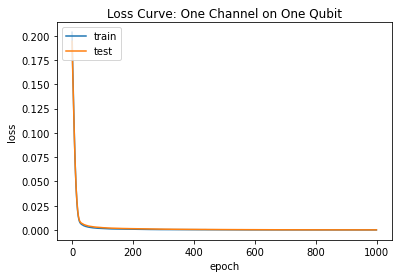

In [44]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: One Channel on One Qubit')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 6.4332e-05 - 209ms/epoch - 30ms/step


In [46]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_mse = tf.math.reduce_mean(fid)
print(fid_one_mse)

tf.Tensor((0.9966008+1.4188117e-12j), shape=(), dtype=complex64)


## <font color='red'>Training the Algorithm (INF)</font>

### <font color='red'>Different Channels on both Qubits</font>

In [75]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [76]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [77]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [78]:
x_train_list = vectors_with_noise[:500]
y_train_list = vectors_noise_free[:500]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [79]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [80]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [81]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 2s 107ms/step - loss: 0.6915 - val_loss: 0.6488
Epoch 2/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.5820 - val_loss: 0.5468
Epoch 3/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.4825 - val_loss: 0.4546
Epoch 4/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.3965 - val_loss: 0.3808
Epoch 5/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.3282 - val_loss: 0.3224
Epoch 6/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2750 - val_loss: 0.2743
Epoch 7/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.2324 - val_loss: 0.2355
Epoch 8/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.1986 - val_loss: 0.2032
Epoch 9/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1693 - val_loss: 0.1764
Epoch 10/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1453 - val_loss: 0.1548
Epoch 11

5/5 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0103
Epoch 84/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0056 - val_loss: 0.0101
Epoch 85/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0100
Epoch 86/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0055 - val_loss: 0.0099
Epoch 87/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 88/1000
5/5 [==============================] - 0s 33ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 89/1000
5/5 [==============================] - 0s 34ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 90/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 91/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0051 - val_loss: 0.0093
Epoch 92/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0050 - val_loss: 0.0092
Epoch 93/1000


5/5 [==============================] - 0s 30ms/step - loss: 0.0025 - val_loss: 0.0056
Epoch 165/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 166/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 167/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 168/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 169/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 170/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 171/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 172/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 173/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0023 - val_loss: 0.0053
Epoch

5/5 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 246/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 247/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 248/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 249/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 250/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 251/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 252/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 253/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 254/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch

5/5 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 327/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 328/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 329/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 330/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 331/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 332/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 333/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 334/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 335/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch

5/5 [==============================] - 0s 16ms/step - loss: 8.5197e-04 - val_loss: 0.0028
Epoch 406/1000
5/5 [==============================] - 0s 22ms/step - loss: 8.3977e-04 - val_loss: 0.0028
Epoch 407/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.4878e-04 - val_loss: 0.0028
Epoch 408/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.4938e-04 - val_loss: 0.0028
Epoch 409/1000
5/5 [==============================] - 0s 17ms/step - loss: 8.4118e-04 - val_loss: 0.0028
Epoch 410/1000
5/5 [==============================] - 0s 22ms/step - loss: 8.4127e-04 - val_loss: 0.0028
Epoch 411/1000
5/5 [==============================] - 0s 28ms/step - loss: 8.5241e-04 - val_loss: 0.0028
Epoch 412/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.3894e-04 - val_loss: 0.0028
Epoch 413/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.4633e-04 - val_loss: 0.0028
Epoch 414/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 18ms/step - loss: 6.7458e-04 - val_loss: 0.0024
Epoch 484/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.6959e-04 - val_loss: 0.0024
Epoch 485/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.6719e-04 - val_loss: 0.0024
Epoch 486/1000
5/5 [==============================] - 0s 16ms/step - loss: 6.7006e-04 - val_loss: 0.0024
Epoch 487/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.6764e-04 - val_loss: 0.0024
Epoch 488/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.5984e-04 - val_loss: 0.0024
Epoch 489/1000
5/5 [==============================] - 0s 24ms/step - loss: 6.6019e-04 - val_loss: 0.0024
Epoch 490/1000
5/5 [==============================] - 0s 20ms/step - loss: 6.5686e-04 - val_loss: 0.0024
Epoch 491/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.5719e-04 - val_loss: 0.0024
Epoch 492/1000
5/5 [==============================] - 0s 18ms/step - l

5/5 [==============================] - 0s 16ms/step - loss: 5.4957e-04 - val_loss: 0.0021
Epoch 562/1000
5/5 [==============================] - 0s 17ms/step - loss: 5.3779e-04 - val_loss: 0.0021
Epoch 563/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.3213e-04 - val_loss: 0.0021
Epoch 564/1000
5/5 [==============================] - 0s 16ms/step - loss: 5.3570e-04 - val_loss: 0.0021
Epoch 565/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.3687e-04 - val_loss: 0.0021
Epoch 566/1000
5/5 [==============================] - 0s 16ms/step - loss: 5.3451e-04 - val_loss: 0.0021
Epoch 567/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.4110e-04 - val_loss: 0.0021
Epoch 568/1000
5/5 [==============================] - 0s 16ms/step - loss: 5.3562e-04 - val_loss: 0.0021
Epoch 569/1000
5/5 [==============================] - 0s 16ms/step - loss: 5.4103e-04 - val_loss: 0.0021
Epoch 570/1000
5/5 [==============================] - 0s 18ms/step - l

5/5 [==============================] - 0s 18ms/step - loss: 4.4699e-04 - val_loss: 0.0019
Epoch 640/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.4434e-04 - val_loss: 0.0019
Epoch 641/1000
5/5 [==============================] - 0s 17ms/step - loss: 4.4785e-04 - val_loss: 0.0019
Epoch 642/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.5221e-04 - val_loss: 0.0019
Epoch 643/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.4321e-04 - val_loss: 0.0019
Epoch 644/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.5403e-04 - val_loss: 0.0019
Epoch 645/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.5359e-04 - val_loss: 0.0019
Epoch 646/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.5842e-04 - val_loss: 0.0019
Epoch 647/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.5718e-04 - val_loss: 0.0019
Epoch 648/1000
5/5 [==============================] - 0s 18ms/step - l

5/5 [==============================] - 0s 16ms/step - loss: 3.7131e-04 - val_loss: 0.0017
Epoch 718/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.7751e-04 - val_loss: 0.0017
Epoch 719/1000
5/5 [==============================] - 0s 24ms/step - loss: 3.8609e-04 - val_loss: 0.0017
Epoch 720/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.9066e-04 - val_loss: 0.0017
Epoch 721/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.9655e-04 - val_loss: 0.0017
Epoch 722/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.9160e-04 - val_loss: 0.0017
Epoch 723/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.9411e-04 - val_loss: 0.0017
Epoch 724/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.8981e-04 - val_loss: 0.0017
Epoch 725/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.8908e-04 - val_loss: 0.0017
Epoch 726/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 18ms/step - loss: 3.4376e-04 - val_loss: 0.0016
Epoch 796/1000
5/5 [==============================] - 0s 24ms/step - loss: 3.3564e-04 - val_loss: 0.0016
Epoch 797/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.3473e-04 - val_loss: 0.0016
Epoch 798/1000
5/5 [==============================] - 0s 21ms/step - loss: 3.3343e-04 - val_loss: 0.0015
Epoch 799/1000
5/5 [==============================] - 0s 17ms/step - loss: 3.3410e-04 - val_loss: 0.0015
Epoch 800/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.3273e-04 - val_loss: 0.0015
Epoch 801/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.2612e-04 - val_loss: 0.0015
Epoch 802/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.2108e-04 - val_loss: 0.0015
Epoch 803/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.1941e-04 - val_loss: 0.0015
Epoch 804/1000
5/5 [==============================] - 0s 18ms/step - l

5/5 [==============================] - 0s 16ms/step - loss: 2.8951e-04 - val_loss: 0.0014
Epoch 874/1000
5/5 [==============================] - 0s 17ms/step - loss: 2.8898e-04 - val_loss: 0.0014
Epoch 875/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.9270e-04 - val_loss: 0.0014
Epoch 876/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.8739e-04 - val_loss: 0.0014
Epoch 877/1000
5/5 [==============================] - 0s 16ms/step - loss: 2.9220e-04 - val_loss: 0.0014
Epoch 878/1000
5/5 [==============================] - 0s 16ms/step - loss: 2.8654e-04 - val_loss: 0.0014
Epoch 879/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.9108e-04 - val_loss: 0.0014
Epoch 880/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.9004e-04 - val_loss: 0.0014
Epoch 881/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.8671e-04 - val_loss: 0.0014
Epoch 882/1000
5/5 [==============================] - 0s 23ms/step - l

5/5 [==============================] - 0s 22ms/step - loss: 2.4571e-04 - val_loss: 0.0013
Epoch 952/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.4130e-04 - val_loss: 0.0013
Epoch 953/1000
5/5 [==============================] - 0s 21ms/step - loss: 2.4195e-04 - val_loss: 0.0013
Epoch 954/1000
5/5 [==============================] - 0s 16ms/step - loss: 2.4327e-04 - val_loss: 0.0013
Epoch 955/1000
5/5 [==============================] - 0s 16ms/step - loss: 2.4034e-04 - val_loss: 0.0013
Epoch 956/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.4066e-04 - val_loss: 0.0013
Epoch 957/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.5326e-04 - val_loss: 0.0013
Epoch 958/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.4789e-04 - val_loss: 0.0013
Epoch 959/1000
5/5 [==============================] - 0s 16ms/step - loss: 2.4847e-04 - val_loss: 0.0013
Epoch 960/1000
5/5 [==============================] - 0s 21ms/step - l

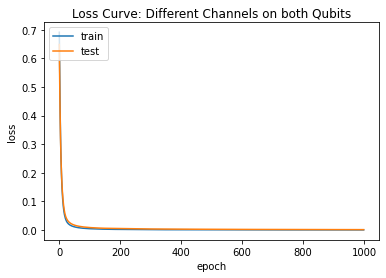

In [82]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0011 - 218ms/epoch - 31ms/step


In [84]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_both_inf = tf.math.reduce_mean(fid)
print(fid_both_inf)

tf.Tensor((0.99891424+3.2014213e-12j), shape=(), dtype=complex64)


### <font color='red'>Same Channel on both Qubits</font>

In [85]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [86]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [87]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [88]:
x_train_list = vectors_with_noise[:500]
y_train_list = vectors_noise_free[:500]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [89]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [90]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [91]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 2s 83ms/step - loss: 0.7023 - val_loss: 0.6349
Epoch 2/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.6099 - val_loss: 0.5552
Epoch 3/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.5207 - val_loss: 0.4757
Epoch 4/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.4362 - val_loss: 0.4020
Epoch 5/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.3617 - val_loss: 0.3391
Epoch 6/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.3018 - val_loss: 0.2896
Epoch 7/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2541 - val_loss: 0.2501
Epoch 8/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.2171 - val_loss: 0.2168
Epoch 9/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.1869 - val_loss: 0.1888
Epoch 10/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1620 - val_loss: 0.1660
Epoch 11/

5/5 [==============================] - 0s 18ms/step - loss: 0.0053 - val_loss: 0.0094
Epoch 84/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0052 - val_loss: 0.0093
Epoch 85/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0051 - val_loss: 0.0092
Epoch 86/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0050 - val_loss: 0.0091
Epoch 87/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0090
Epoch 88/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0049 - val_loss: 0.0089
Epoch 89/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0048 - val_loss: 0.0088
Epoch 90/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0047 - val_loss: 0.0087
Epoch 91/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0047 - val_loss: 0.0086
Epoch 92/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0046 - val_loss: 0.0085
Epoch 93/1000


5/5 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0049
Epoch 165/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 166/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 167/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 168/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 169/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 170/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 171/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 172/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 173/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch

5/5 [==============================] - 0s 23ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 246/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 247/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 248/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 249/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 250/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 251/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 252/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 253/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 254/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch

5/5 [==============================] - 0s 22ms/step - loss: 9.5754e-04 - val_loss: 0.0027
Epoch 326/1000
5/5 [==============================] - 0s 25ms/step - loss: 9.2757e-04 - val_loss: 0.0027
Epoch 327/1000
5/5 [==============================] - 0s 22ms/step - loss: 9.3121e-04 - val_loss: 0.0027
Epoch 328/1000
5/5 [==============================] - 0s 20ms/step - loss: 9.3379e-04 - val_loss: 0.0027
Epoch 329/1000
5/5 [==============================] - 0s 20ms/step - loss: 9.2876e-04 - val_loss: 0.0027
Epoch 330/1000
5/5 [==============================] - 0s 20ms/step - loss: 9.1710e-04 - val_loss: 0.0027
Epoch 331/1000
5/5 [==============================] - 0s 18ms/step - loss: 9.1175e-04 - val_loss: 0.0027
Epoch 332/1000
5/5 [==============================] - 0s 19ms/step - loss: 9.1714e-04 - val_loss: 0.0027
Epoch 333/1000
5/5 [==============================] - 0s 23ms/step - loss: 9.1391e-04 - val_loss: 0.0027
Epoch 334/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 20ms/step - loss: 7.2270e-04 - val_loss: 0.0022
Epoch 404/1000
5/5 [==============================] - 0s 24ms/step - loss: 7.0177e-04 - val_loss: 0.0022
Epoch 405/1000
5/5 [==============================] - 0s 26ms/step - loss: 7.0627e-04 - val_loss: 0.0022
Epoch 406/1000
5/5 [==============================] - 0s 30ms/step - loss: 7.0821e-04 - val_loss: 0.0022
Epoch 407/1000
5/5 [==============================] - 0s 24ms/step - loss: 6.9674e-04 - val_loss: 0.0022
Epoch 408/1000
5/5 [==============================] - 0s 22ms/step - loss: 6.9591e-04 - val_loss: 0.0022
Epoch 409/1000
5/5 [==============================] - 0s 22ms/step - loss: 6.9221e-04 - val_loss: 0.0022
Epoch 410/1000
5/5 [==============================] - 0s 24ms/step - loss: 6.9957e-04 - val_loss: 0.0022
Epoch 411/1000
5/5 [==============================] - 0s 24ms/step - loss: 6.9547e-04 - val_loss: 0.0022
Epoch 412/1000
5/5 [==============================] - 0s 24ms/step - l

5/5 [==============================] - 0s 22ms/step - loss: 5.7572e-04 - val_loss: 0.0019
Epoch 482/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.7332e-04 - val_loss: 0.0019
Epoch 483/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.7255e-04 - val_loss: 0.0019
Epoch 484/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.6905e-04 - val_loss: 0.0019
Epoch 485/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.6852e-04 - val_loss: 0.0019
Epoch 486/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.6031e-04 - val_loss: 0.0019
Epoch 487/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.5790e-04 - val_loss: 0.0019
Epoch 488/1000
5/5 [==============================] - 0s 21ms/step - loss: 5.5762e-04 - val_loss: 0.0019
Epoch 489/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.4669e-04 - val_loss: 0.0019
Epoch 490/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 26ms/step - loss: 4.4466e-04 - val_loss: 0.0016
Epoch 560/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.4438e-04 - val_loss: 0.0016
Epoch 561/1000
5/5 [==============================] - 0s 23ms/step - loss: 4.5101e-04 - val_loss: 0.0016
Epoch 562/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.4973e-04 - val_loss: 0.0017
Epoch 563/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.5393e-04 - val_loss: 0.0017
Epoch 564/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.5565e-04 - val_loss: 0.0017
Epoch 565/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.5136e-04 - val_loss: 0.0016
Epoch 566/1000
5/5 [==============================] - 0s 26ms/step - loss: 4.5897e-04 - val_loss: 0.0016
Epoch 567/1000
5/5 [==============================] - 0s 24ms/step - loss: 4.5078e-04 - val_loss: 0.0016
Epoch 568/1000
5/5 [==============================] - 0s 23ms/step - l

5/5 [==============================] - 0s 21ms/step - loss: 3.7665e-04 - val_loss: 0.0015
Epoch 638/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.7610e-04 - val_loss: 0.0014
Epoch 639/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.7907e-04 - val_loss: 0.0014
Epoch 640/1000
5/5 [==============================] - 0s 17ms/step - loss: 3.7672e-04 - val_loss: 0.0014
Epoch 641/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.7875e-04 - val_loss: 0.0014
Epoch 642/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.8193e-04 - val_loss: 0.0014
Epoch 643/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.8504e-04 - val_loss: 0.0014
Epoch 644/1000
5/5 [==============================] - 0s 25ms/step - loss: 3.8692e-04 - val_loss: 0.0014
Epoch 645/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.8803e-04 - val_loss: 0.0014
Epoch 646/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 19ms/step - loss: 3.1693e-04 - val_loss: 0.0013
Epoch 716/1000
5/5 [==============================] - 0s 21ms/step - loss: 3.0817e-04 - val_loss: 0.0013
Epoch 717/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.1244e-04 - val_loss: 0.0013
Epoch 718/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.1085e-04 - val_loss: 0.0013
Epoch 719/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.1638e-04 - val_loss: 0.0013
Epoch 720/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.1186e-04 - val_loss: 0.0013
Epoch 721/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.0675e-04 - val_loss: 0.0013
Epoch 722/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.0741e-04 - val_loss: 0.0013
Epoch 723/1000
5/5 [==============================] - 0s 24ms/step - loss: 3.1582e-04 - val_loss: 0.0013
Epoch 724/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 24ms/step - loss: 2.6455e-04 - val_loss: 0.0011
Epoch 794/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.5923e-04 - val_loss: 0.0011
Epoch 795/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.5967e-04 - val_loss: 0.0011
Epoch 796/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.5556e-04 - val_loss: 0.0011
Epoch 797/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.5326e-04 - val_loss: 0.0011
Epoch 798/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.5501e-04 - val_loss: 0.0011
Epoch 799/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.5436e-04 - val_loss: 0.0011
Epoch 800/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.5892e-04 - val_loss: 0.0011
Epoch 801/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.5812e-04 - val_loss: 0.0011
Epoch 802/1000
5/5 [==============================] - 0s 19ms/step - l

Epoch 871/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.2378e-04 - val_loss: 9.7507e-04
Epoch 872/1000
5/5 [==============================] - 0s 21ms/step - loss: 2.1994e-04 - val_loss: 9.7794e-04
Epoch 873/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.1917e-04 - val_loss: 9.8245e-04
Epoch 874/1000
5/5 [==============================] - 0s 25ms/step - loss: 2.1586e-04 - val_loss: 9.9064e-04
Epoch 875/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.1722e-04 - val_loss: 9.7604e-04
Epoch 876/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.1172e-04 - val_loss: 9.8033e-04
Epoch 877/1000
5/5 [==============================] - 0s 26ms/step - loss: 2.1314e-04 - val_loss: 9.6871e-04
Epoch 878/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.1824e-04 - val_loss: 9.7780e-04
Epoch 879/1000
5/5 [==============================] - 0s 23ms/step - loss: 2.1759e-04 - val_loss: 9.6168e-04
Epoch 880/1000
5/5 

5/5 [==============================] - 0s 24ms/step - loss: 1.9309e-04 - val_loss: 8.9223e-04
Epoch 947/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.9154e-04 - val_loss: 8.8443e-04
Epoch 948/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.8781e-04 - val_loss: 8.8147e-04
Epoch 949/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.8615e-04 - val_loss: 8.8415e-04
Epoch 950/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.8921e-04 - val_loss: 8.7488e-04
Epoch 951/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.8772e-04 - val_loss: 8.8275e-04
Epoch 952/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.9465e-04 - val_loss: 8.8459e-04
Epoch 953/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.0538e-04 - val_loss: 8.7193e-04
Epoch 954/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.0620e-04 - val_loss: 8.9020e-04
Epoch 955/1000
5/5 [==============

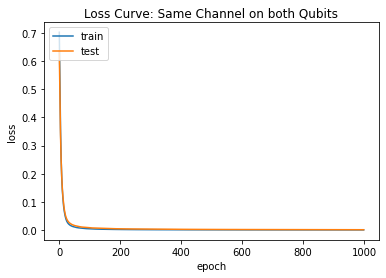

In [92]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [93]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 8.1845e-04 - 241ms/epoch - 34ms/step


In [94]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_inf = tf.math.reduce_mean(fid)
print(fid_same_inf)

tf.Tensor((0.9991815-1.1277734e-11j), shape=(), dtype=complex64)


### <font color='red'>One Channel on one Qubit</font>

In [95]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [96]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [97]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [98]:
x_train_list = vectors_with_noise[:500]
y_train_list = vectors_noise_free[:500]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [99]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [100]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [101]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 2s 76ms/step - loss: 0.7569 - val_loss: 0.7055
Epoch 2/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.6671 - val_loss: 0.6328
Epoch 3/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.5861 - val_loss: 0.5604
Epoch 4/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.5023 - val_loss: 0.4810
Epoch 5/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.4146 - val_loss: 0.3964
Epoch 6/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.3310 - val_loss: 0.3169
Epoch 7/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2651 - val_loss: 0.2553
Epoch 8/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2182 - val_loss: 0.2108
Epoch 9/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1814 - val_loss: 0.1783
Epoch 10/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1518 - val_loss: 0.1528
Epoch 11/

5/5 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0.0113
Epoch 84/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0060 - val_loss: 0.0112
Epoch 85/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.0059 - val_loss: 0.0110
Epoch 86/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0058 - val_loss: 0.0110
Epoch 87/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0057 - val_loss: 0.0108
Epoch 88/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0107
Epoch 89/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 90/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0055 - val_loss: 0.0105
Epoch 91/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0054 - val_loss: 0.0104
Epoch 92/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0053 - val_loss: 0.0103
Epoch 93/1000


5/5 [==============================] - 0s 19ms/step - loss: 0.0027 - val_loss: 0.0065
Epoch 165/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0026 - val_loss: 0.0064
Epoch 166/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0026 - val_loss: 0.0064
Epoch 167/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 0.0064
Epoch 168/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.0026 - val_loss: 0.0064
Epoch 169/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 0.0063
Epoch 170/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0026 - val_loss: 0.0063
Epoch 171/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0025 - val_loss: 0.0062
Epoch 172/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.0025 - val_loss: 0.0062
Epoch 173/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0062
Epoch

5/5 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 246/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 247/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 248/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 249/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 250/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 251/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 252/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 253/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 254/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch

5/5 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 327/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 328/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 329/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 330/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 331/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 332/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 333/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 334/1000
5/5 [==============================] - 0s 35ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 335/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch

5/5 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 408/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 409/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 410/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 411/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 412/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 413/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 414/1000
5/5 [==============================] - 0s 20ms/step - loss: 9.9700e-04 - val_loss: 0.0038
Epoch 415/1000
5/5 [==============================] - 0s 19ms/step - loss: 9.9431e-04 - val_loss: 0.0038
Epoch 416/1000
5/5 [==============================] - 0s 20ms/step - loss: 9.8968e-04 - val_loss: 

5/5 [==============================] - 0s 18ms/step - loss: 8.4014e-04 - val_loss: 0.0035
Epoch 486/1000
5/5 [==============================] - 0s 20ms/step - loss: 8.3956e-04 - val_loss: 0.0035
Epoch 487/1000
5/5 [==============================] - 0s 19ms/step - loss: 8.4073e-04 - val_loss: 0.0035
Epoch 488/1000
5/5 [==============================] - 0s 19ms/step - loss: 8.2562e-04 - val_loss: 0.0035
Epoch 489/1000
5/5 [==============================] - 0s 21ms/step - loss: 8.3300e-04 - val_loss: 0.0035
Epoch 490/1000
5/5 [==============================] - 0s 22ms/step - loss: 8.3617e-04 - val_loss: 0.0035
Epoch 491/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.3142e-04 - val_loss: 0.0035
Epoch 492/1000
5/5 [==============================] - 0s 22ms/step - loss: 8.4175e-04 - val_loss: 0.0035
Epoch 493/1000
5/5 [==============================] - 0s 19ms/step - loss: 8.3481e-04 - val_loss: 0.0034
Epoch 494/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 21ms/step - loss: 7.0987e-04 - val_loss: 0.0032
Epoch 564/1000
5/5 [==============================] - 0s 18ms/step - loss: 7.1458e-04 - val_loss: 0.0032
Epoch 565/1000
5/5 [==============================] - 0s 18ms/step - loss: 7.2176e-04 - val_loss: 0.0032
Epoch 566/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.2243e-04 - val_loss: 0.0033
Epoch 567/1000
5/5 [==============================] - 0s 22ms/step - loss: 7.2604e-04 - val_loss: 0.0032
Epoch 568/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.2068e-04 - val_loss: 0.0033
Epoch 569/1000
5/5 [==============================] - 0s 25ms/step - loss: 7.3326e-04 - val_loss: 0.0033
Epoch 570/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.3199e-04 - val_loss: 0.0033
Epoch 571/1000
5/5 [==============================] - 0s 21ms/step - loss: 7.2601e-04 - val_loss: 0.0032
Epoch 572/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 21ms/step - loss: 6.2019e-04 - val_loss: 0.0031
Epoch 642/1000
5/5 [==============================] - 0s 24ms/step - loss: 6.2211e-04 - val_loss: 0.0031
Epoch 643/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.1940e-04 - val_loss: 0.0031
Epoch 644/1000
5/5 [==============================] - 0s 20ms/step - loss: 6.1723e-04 - val_loss: 0.0031
Epoch 645/1000
5/5 [==============================] - 0s 19ms/step - loss: 6.1048e-04 - val_loss: 0.0031
Epoch 646/1000
5/5 [==============================] - 0s 25ms/step - loss: 6.1614e-04 - val_loss: 0.0031
Epoch 647/1000
5/5 [==============================] - 0s 24ms/step - loss: 6.0729e-04 - val_loss: 0.0031
Epoch 648/1000
5/5 [==============================] - 0s 24ms/step - loss: 6.0005e-04 - val_loss: 0.0031
Epoch 649/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.0602e-04 - val_loss: 0.0031
Epoch 650/1000
5/5 [==============================] - 0s 22ms/step - l

5/5 [==============================] - 0s 26ms/step - loss: 5.4014e-04 - val_loss: 0.0030
Epoch 720/1000
5/5 [==============================] - 0s 16ms/step - loss: 5.4406e-04 - val_loss: 0.0030
Epoch 721/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.3937e-04 - val_loss: 0.0029
Epoch 722/1000
5/5 [==============================] - 0s 17ms/step - loss: 5.3976e-04 - val_loss: 0.0029
Epoch 723/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.3589e-04 - val_loss: 0.0030
Epoch 724/1000
5/5 [==============================] - 0s 19ms/step - loss: 5.3572e-04 - val_loss: 0.0029
Epoch 725/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.3292e-04 - val_loss: 0.0029
Epoch 726/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.3680e-04 - val_loss: 0.0030
Epoch 727/1000
5/5 [==============================] - 0s 21ms/step - loss: 5.3878e-04 - val_loss: 0.0029
Epoch 728/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 19ms/step - loss: 4.9433e-04 - val_loss: 0.0028
Epoch 798/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.9714e-04 - val_loss: 0.0029
Epoch 799/1000
5/5 [==============================] - 0s 19ms/step - loss: 4.9875e-04 - val_loss: 0.0029
Epoch 800/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.0005e-04 - val_loss: 0.0029
Epoch 801/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.9353e-04 - val_loss: 0.0028
Epoch 802/1000
5/5 [==============================] - 0s 19ms/step - loss: 4.9190e-04 - val_loss: 0.0029
Epoch 803/1000
5/5 [==============================] - 0s 21ms/step - loss: 4.9878e-04 - val_loss: 0.0028
Epoch 804/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.8937e-04 - val_loss: 0.0028
Epoch 805/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.9060e-04 - val_loss: 0.0028
Epoch 806/1000
5/5 [==============================] - 0s 18ms/step - l

5/5 [==============================] - 0s 21ms/step - loss: 4.3351e-04 - val_loss: 0.0027
Epoch 876/1000
5/5 [==============================] - 0s 21ms/step - loss: 4.4722e-04 - val_loss: 0.0028
Epoch 877/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.4301e-04 - val_loss: 0.0028
Epoch 878/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.5909e-04 - val_loss: 0.0027
Epoch 879/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.3794e-04 - val_loss: 0.0027
Epoch 880/1000
5/5 [==============================] - 0s 21ms/step - loss: 4.3304e-04 - val_loss: 0.0027
Epoch 881/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.3127e-04 - val_loss: 0.0027
Epoch 882/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.3032e-04 - val_loss: 0.0027
Epoch 883/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.4152e-04 - val_loss: 0.0027
Epoch 884/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 22ms/step - loss: 4.1151e-04 - val_loss: 0.0027
Epoch 954/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.1680e-04 - val_loss: 0.0027
Epoch 955/1000
5/5 [==============================] - 0s 19ms/step - loss: 4.1209e-04 - val_loss: 0.0027
Epoch 956/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.9518e-04 - val_loss: 0.0026
Epoch 957/1000
5/5 [==============================] - 0s 21ms/step - loss: 3.9133e-04 - val_loss: 0.0026
Epoch 958/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.9598e-04 - val_loss: 0.0026
Epoch 959/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.8819e-04 - val_loss: 0.0026
Epoch 960/1000
5/5 [==============================] - 0s 23ms/step - loss: 3.9401e-04 - val_loss: 0.0026
Epoch 961/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.9508e-04 - val_loss: 0.0027
Epoch 962/1000
5/5 [==============================] - 0s 18ms/step - l

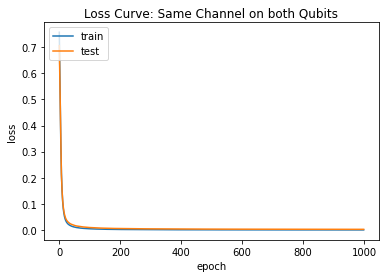

In [102]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0025 - 211ms/epoch - 30ms/step


In [104]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_inf = tf.math.reduce_mean(fid)
print(fid_one_inf)

tf.Tensor((0.9974693+1.731678e-11j), shape=(), dtype=complex64)
